# Yelp Reviews: LSTM: Classification using Polarity (Negative vs Positive) on Reviews

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import warnings
import pandas as pd
import datetime
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Embedding, Dropout, Bidirectional, LSTM
from keras.layers import GlobalMaxPool1D, Activation, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
warnings.filterwarnings('ignore')
my_dpi = 96
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
print('\n')
print('TensorFlow version: {}'.format(tf.__version__))
print('Eager execution is: {}'.format(tf.executing_eagerly()))
print('Keras version: {}'.format(tf.keras.__version__))
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Wed May 18 23:17:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|            

In [ ]:
# Reproducibility in TF and Pytorch
def init_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] = 'True'
    os.environ['TF_DETERMINISTIC_OPS'] = 'True'
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=42)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read reviews with sentiment
df = pd.read_parquet('YelpReviews_NLP_sentimentNegPos.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (829874, 3)


,cleanReview,sentiment,stars_reviews
index,,,
1,order chicken finger sub honey mustard sauce p...,Negative,3.0
3,dedicated loving memory gary feldman greatest ...,Negative,5.0
12,absolutely horrible thought would order place ...,Negative,1.0
15,found better chicken finger know inside crisp ...,Negative,4.0
20,amazing everything tried disappoint chicken ca...,Negative,5.0


In [ ]:
# Examine how star reviews pairs with sentiment polarity
print(df[['stars_reviews', 'sentiment']].value_counts())

stars_reviews  sentiment
5.0            Positive     278011
1.0            Negative     231245
4.0            Positive     104585
2.0            Negative      90320
3.0            Negative      44097
4.0            Negative      26276
5.0            Negative      22999
3.0            Positive      22096
2.0            Positive       6690
1.0            Positive       3555
dtype: int64


In [ ]:
# Recode to binary
df['sentiment'].mask(df['sentiment'] == 'Negative', 0, inplace=True)
df['sentiment'].mask(df['sentiment'] == 'Positive', 1, inplace=True)

print('Number of reviews per group:')
df[['sentiment']].value_counts()

Number of reviews per group:


sentiment
0            414937
1            414937
dtype: int64

In [ ]:
# Convert data types
df['sentiment'] = df['sentiment'].astype('int')
df = df.drop(['stars_reviews'], axis=1)
df = shuffle(df)

In [ ]:
# Set up label and features
label = df[['sentiment']]
features = df.cleanReview

In [ ]:
# Partition data for train/test
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.1,
                                                    stratify=label,
                                                    random_state=42)

## Length = 500 & Batch Size = 1024

In [ ]:
class KerasTokenizer(object):
    """
    Fit and convert text to sequences for use in a Keras model.
    num_words = max number of words
    maxlen = max length of sequences
    """
    def __init__(self, num_words=100000, maxlen=500):
        self.tokenizer = text.Tokenizer(num_words=num_words)
        self.maxlen = maxlen

    def fit(self, X, y):
        self.tokenizer.fit_on_texts(X)
        return self

    def transform(self, X):
        return sequence.pad_sequences(self.tokenizer.texts_to_sequences(X),
                                      maxlen=self.maxlen)

In [ ]:
# Tokenize train/test sets
km  = Pipeline([('Keras Tokenizer', KerasTokenizer(num_words=100000,
                                                   maxlen=500))])
X_trainT = km.fit_transform(X_train)
X_testT = km.fit_transform(X_test)

In [ ]:
# Write results to DL Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/DL/LSTM/SentimentPolarity/Models/

In [ ]:
# Set up logs
!rm -rf /logs/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [ ]:
# Set up callbacks
filepath = 'Polarity_LSTM_weights_only_len500_batch1024.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=3),
                  ModelCheckpoint(filepath, monitor='val_accuracy',
                                  save_best_only=True, mode='max'),
                  tensorboard_callback]

In [ ]:
# Define model structure
embedding_size = 300
input_ = Input(shape=(500,))
x = Embedding(100000, embedding_size)(input_)
x = Dropout(0.1)(x)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1,
                       recurrent_dropout=0.0))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='tanh')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_, outputs=x)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          30000000  
                                                                 
 dropout (Dropout)           (None, 500, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 500, 100)         140400    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050  

In [ ]:
# Train model
history = model.fit(X_trainT, y_train, validation_data=(X_testT, y_test),
                    epochs=5, batch_size=1024, callbacks=callbacks_list)

Epoch 1/5
730/730 [==============================] - 557s 751ms/step - loss: 0.0296 - accuracy: 0.9890 - val_loss: 0.3331 - val_accuracy: 0.9244
Epoch 2/5
730/730 [==============================] - 546s 748ms/step - loss: 9.1795e-04 - accuracy: 0.9998 - val_loss: 0.4083 - val_accuracy: 0.9237
Epoch 3/5
730/730 [==============================] - 546s 748ms/step - loss: 3.2027e-04 - accuracy: 0.9999 - val_loss: 0.4607 - val_accuracy: 0.9229
Epoch 4/5
730/730 [==============================] - 547s 749ms/step - loss: 1.8090e-04 - accuracy: 1.0000 - val_loss: 0.5081 - val_accuracy: 0.9219


In [ ]:
# Save model
model.save('./Polarity_LSTM_len500_batch1024_tf.h5', save_format='tf')

# Load model for more training or later use
#filepath = 'Polarity_LSTM_weights_only_len500_batch1024.h5'
#model = tf.keras.models.load_model('./Polarity_LSTM_len500_batch1024_tf.h5')
#model.load(weights)

# Show the model architecture
#model.summary()

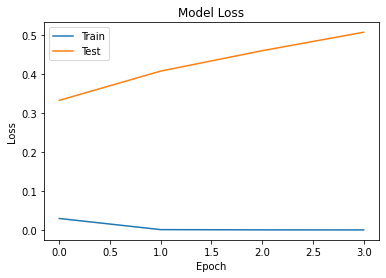

In [ ]:
# Plot loss over epochs
plt.title('Model Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('LSTM_len500_batch1024_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

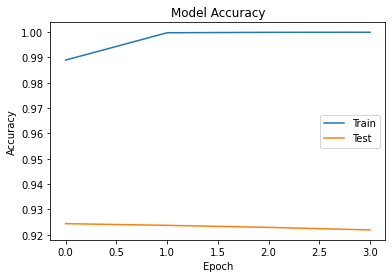

In [ ]:
# Plot accuracy over epochs
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('LSTM_len500_batch1024_Accuracy.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
# Accuracy in test set
acc = model.evaluate(X_testT, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0], acc[1]))

2594/2594 [==============================] - 50s 19ms/step - loss: 0.5081 - accuracy: 0.9219
Test set
  Loss: 0.508
  Accuracy: 0.922


In [ ]:
# Define function for sentiment score
def decode_sentiment(score):
    return 1 if score>0.5 else 0

In [ ]:
# Predict on the test set
scores = model.predict(X_testT, verbose=1)

2594/2594 [==============================] - 46s 17ms/step


In [ ]:
# Determine sentiment score of test set
y_pred_1d = [decode_sentiment(score) for score in scores]

In [ ]:
# Define function for constructing confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Print and plot the confusion matrix
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

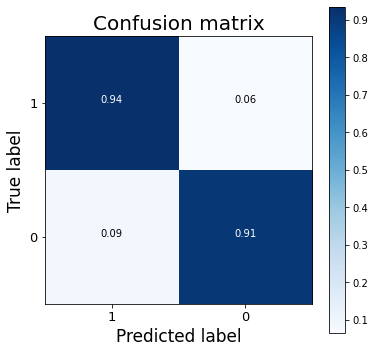

In [ ]:
# Confusion matrix
cnf_matrix = confusion_matrix(y_test['sentiment'].tolist(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=y_test.sentiment.unique(),
                      title='Confusion matrix')
plt.savefig('LSTM_len500_batch1024_CF.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
# Classifcation score for model
print(classification_report(y_test['sentiment'].tolist(), y_pred_1d))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     41494
           1       0.93      0.91      0.92     41494

    accuracy                           0.92     82988
   macro avg       0.92      0.92      0.92     82988
weighted avg       0.92      0.92      0.92     82988



## Length = 500 & Batch Size = 256

In [ ]:
# Write results to DL Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/DL/LSTM/SentimentPolarity/Models/

In [ ]:
# Set up logs
!rm -rf /logs/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [ ]:
# Set up callbacks
filepath = 'Polarity_LSTM_weights_only_len500_b256.h5'


checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=5),
                  ModelCheckpoint(filepath, monitor='val_accuracy',
                                  save_best_only=True, mode='max'),
                  tensorboard_callback]

In [ ]:
# Define model structure
embedding_size = 300
input_ = Input(shape=(500,))
x = Embedding(100000, embedding_size)(input_)
x = Dropout(0.1)(x)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1,
                       recurrent_dropout=0.0))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_, outputs=x)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          30000000  
                                                                 
 dropout (Dropout)           (None, 500, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 500, 100)         140400    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050  

In [ ]:
# Train model
history = model.fit(X_trainT, y_train, validation_data=(X_testT, y_test),
                    epochs=5, batch_size=256, callbacks=callbacks_list)

Epoch 1/5
2918/2918 [==============================] - 777s 266ms/step - loss: 8.3672e-04 - accuracy: 0.9997 - val_loss: 0.2801 - val_accuracy: 0.9480
Epoch 2/5
2918/2918 [==============================] - 774s 265ms/step - loss: 4.0997e-04 - accuracy: 0.9999 - val_loss: 0.3483 - val_accuracy: 0.9478
Epoch 3/5
2918/2918 [==============================] - 774s 265ms/step - loss: 1.8674e-04 - accuracy: 0.9999 - val_loss: 0.3875 - val_accuracy: 0.9493
Epoch 4/5
2918/2918 [==============================] - 773s 265ms/step - loss: 1.6661e-04 - accuracy: 1.0000 - val_loss: 0.3856 - val_accuracy: 0.9470
Epoch 5/5
2918/2918 [==============================] - 774s 265ms/step - loss: 5.6549e-05 - accuracy: 1.0000 - val_loss: 0.4816 - val_accuracy: 0.9481


In [ ]:
# Save model
model.save('./Polarity_LSTM_len500_batch256_tf.h5', save_format='tf')

# Load model for more training or later use
#filepath = 'Polarity_LSTM_weights_only_len500_b256.h5'
#model = tf.keras.models.load_model('./Polarity_LSTM_len500_batch256_tf.h5')
#model.load(weights)

# Show the model architecture
#model.summary()

In [ ]:
# Accuracy in test set
acc = model.evaluate(X_testT, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0], acc[1]))

2594/2594 [==============================] - 52s 20ms/step - loss: 0.4816 - accuracy: 0.9481
Test set
  Loss: 0.482
  Accuracy: 0.948


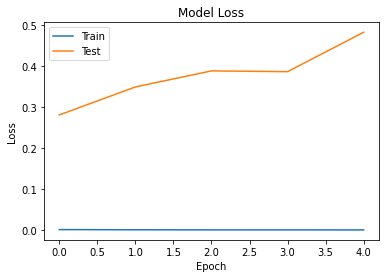

In [ ]:
# Plot loss over epochs
plt.title('Model Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('LSTM_len500_batch256_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

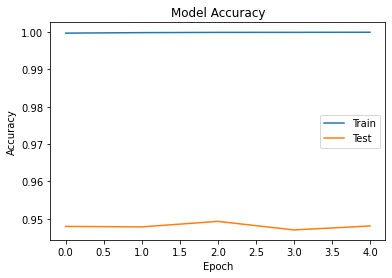

In [ ]:
# Plot accuracy over epochs
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('LSTM_len500_batch256.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
# Load model for more training or later use
model = tf.keras.models.load_model('./Polarity_LSTM_len500_batch256_tf.h5')

# Show the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          30000000  
                                                                 
 dropout (Dropout)           (None, 500, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 500, 100)         140400    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050  

In [ ]:
# Set up callbacks
filepath = 'LSTM_weights_only_len500_b256_2.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=5),
                  ModelCheckpoint(filepath, monitor='val_accuracy',
                                  save_best_only=True, mode='max'),
                  tensorboard_callback]

In [ ]:
# Train model
history = model.fit(X_trainT, y_train, validation_data=(X_testT, y_test),
                    epochs=7, batch_size=256, callbacks=callbacks_list)

Epoch 1/7
2918/2918 [==============================] - 780s 267ms/step - loss: 9.5815e-06 - accuracy: 1.0000 - val_loss: 0.6626 - val_accuracy: 0.9415
Epoch 2/7
2918/2918 [==============================] - 774s 265ms/step - loss: 6.4761e-05 - accuracy: 1.0000 - val_loss: 0.5291 - val_accuracy: 0.9478
Epoch 3/7
2918/2918 [==============================] - 774s 265ms/step - loss: 6.9872e-05 - accuracy: 1.0000 - val_loss: 0.5689 - val_accuracy: 0.9431
Epoch 4/7
2918/2918 [==============================] - 771s 264ms/step - loss: 2.7031e-05 - accuracy: 1.0000 - val_loss: 0.6000 - val_accuracy: 0.9467
Epoch 5/7
2918/2918 [==============================] - 770s 264ms/step - loss: 3.8727e-05 - accuracy: 1.0000 - val_loss: 0.6195 - val_accuracy: 0.9472
Epoch 6/7
2918/2918 [==============================] - 761s 261ms/step - loss: 2.2050e-07 - accuracy: 1.0000 - val_loss: 0.6589 - val_accuracy: 0.9464
Epoch 7/7
2918/2918 [==============================] - 762s 261ms/step - loss: 3.8500e-08 - ac

In [ ]:
# Save model
model.save('./LSTM_len500_batch256_2_tf.h5', save_format='tf')

# Load model for more training or later use
#model = tf.keras.models.load_model('./LSTM_batch256_2_tf.h5')

# Show the model architecture
#model.summary()

In [ ]:
# Accuracy in test set
acc = model.evaluate(X_testT, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0], acc[1]))

2594/2594 [==============================] - 52s 20ms/step - loss: 0.6903 - accuracy: 0.9464
Test set
  Loss: 0.690
  Accuracy: 0.946


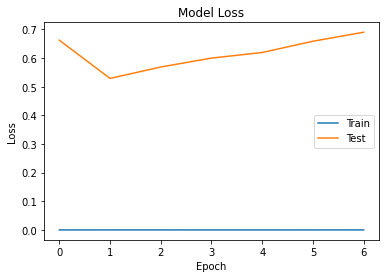

In [ ]:
# Plot loss over epochs
plt.title('Model Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('LSTM_len500_batch256_2_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

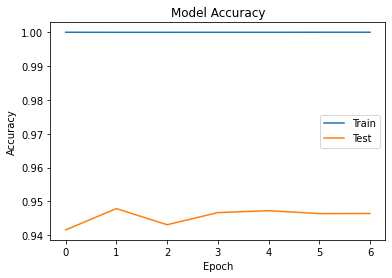

In [ ]:
# Plot accuracy over epochs
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('LSTM_len500_batch256_2_Accuracy.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
# Predict on the test set
scores = model.predict(X_testT, verbose=1)

2594/2594 [==============================] - 49s 18ms/step


In [ ]:
# Determine sentiment score of test set
y_pred_1d = [decode_sentiment(score) for score in scores]

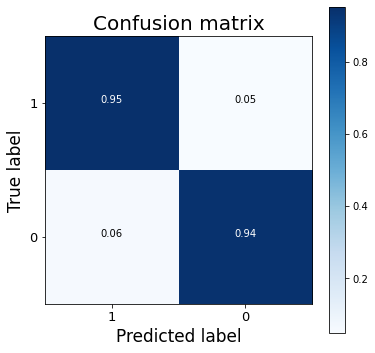

In [ ]:
# Confusion matrix
cnf_matrix = confusion_matrix(y_test['sentiment'].tolist(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=y_test.sentiment.unique(),
                      title='Confusion matrix')
plt.savefig('LSTM_len500_batch256_CF.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
# Classifcation score for model
print(classification_report(y_test['sentiment'].tolist(), y_pred_1d))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     41494
           1       0.95      0.94      0.95     41494

    accuracy                           0.95     82988
   macro avg       0.95      0.95      0.95     82988
weighted avg       0.95      0.95      0.95     82988



## Length = 300 & Batch Size = 1024

In [ ]:
# Tokenize train/test sets
km  = Pipeline([('Keras Tokenizer', KerasTokenizer(num_words=100000,
                                                   maxlen=300))])
X_trainT = km.fit_transform(X_train)
X_testT = km.fit_transform(X_test)

In [ ]:
# Write results to DL Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/DL/LSTM/SentimentPolarity/Models/

In [ ]:
# Set up logs
!rm -rf /logs/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [ ]:
# Set up callbacks
filepath = 'Polarity_LSTM_weights_only_len300_b1024.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=3),
                  ModelCheckpoint(filepath, monitor='val_accuracy',
                                  save_best_only=True, mode='max'),
                  tensorboard_callback]

In [ ]:
# Define model structure
embedding_size = 300
input_ = Input(shape=(300,))
x = Embedding(100000, embedding_size)(input_)
x = Dropout(0.1)(x)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1,
                       recurrent_dropout=0.0))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='tanh')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_, outputs=x)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          30000000  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 100)         140400    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050  

In [ ]:
# Train model
history = model.fit(X_trainT, y_train, validation_data=(X_testT, y_test),
                    epochs=5, batch_size=1024, callbacks=callbacks_list)

Epoch 1/5
730/730 [==============================] - 338s 463ms/step - loss: 1.5008e-04 - accuracy: 1.0000 - val_loss: 0.5485 - val_accuracy: 0.9234
Epoch 2/5
730/730 [==============================] - 338s 463ms/step - loss: 1.5786e-04 - accuracy: 0.9999 - val_loss: 0.5614 - val_accuracy: 0.9263
Epoch 3/5
730/730 [==============================] - 338s 463ms/step - loss: 2.0353e-04 - accuracy: 0.9999 - val_loss: 0.5990 - val_accuracy: 0.9239
Epoch 4/5
730/730 [==============================] - 338s 463ms/step - loss: 1.3298e-04 - accuracy: 0.9999 - val_loss: 0.7381 - val_accuracy: 0.9080


In [ ]:
# Save model
model.save('./Polarity_LSTM_len300_batch1024_tf.h5', save_format='tf')
5
# Load model for more training or later use
#filepath = 'Polarity_LSTM_weights_only_len300_b1024.h5'
#model = tf.keras.models.load_model('./Polarity_LSTM_len300_batch1024_tf.h5')
#model.load(weights)

# Show the model architecture
#model.summary()

5

In [ ]:
# Accuracy in test set
acc = model.evaluate(X_testT, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0], acc[1]))

2594/2594 [==============================] - 40s 15ms/step - loss: 0.7381 - accuracy: 0.9080
Test set
  Loss: 0.738
  Accuracy: 0.908


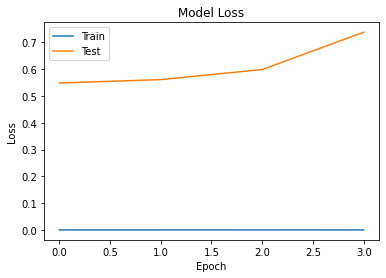

In [ ]:
# Plot loss over epochs
plt.title('Model Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('LSTM_len300_batch1024_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

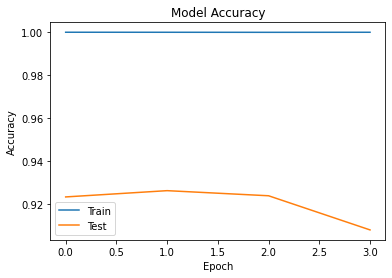

In [ ]:
# Plot accuracy over epochs
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('LSTM_len300_batch1024.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
# Predict on the test set
scores = model.predict(X_testT, verbose=1)

2594/2594 [==============================] - 35s 13ms/step


In [ ]:
# Determine sentiment score of test set
y_pred_1d = [decode_sentiment(score) for score in scores]

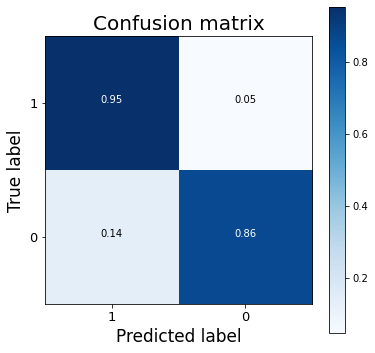

In [ ]:
# Confusion matrix
cnf_matrix = confusion_matrix(y_test['sentiment'].tolist(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=y_test.sentiment.unique(),
                      title='Confusion matrix')
plt.savefig('LSTM_len300_batch1024_CF.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
# Classification score for model
print(classification_report(y_test['sentiment'].tolist(), y_pred_1d))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     41494
           1       0.95      0.86      0.90     41494

    accuracy                           0.91     82988
   macro avg       0.91      0.91      0.91     82988
weighted avg       0.91      0.91      0.91     82988



## Length = 300 & Batch Size = 8

In [ ]:
# Write results to DL Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/DL/LSTM/SentimentPolarity/Models/

In [ ]:
# Set up logs
!rm -rf /logs/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [ ]:
# Set up callbacks
filepath = 'Polarity_LSTM_weights_only_len300_batch8.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=5),
                  ModelCheckpoint(filepath, monitor='val_accuracy',
                                  save_best_only=True, mode='max'),
                  tensorboard_callback]

In [ ]:
# Define model structure
embedding_size = 300
input_ = Input(shape=(300,))
x = Embedding(100000, embedding_size)(input_)
x = Dropout(0.1)(x)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1,
                       recurrent_dropout=0.0))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='tanh')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_, outputs=x)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          30000000  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 100)         140400    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050  

In [ ]:
# Train model
history = model.fit(X_trainT, y_train, validation_data=(X_testT, y_test),
                    epochs=15, batch_size=8, callbacks=callbacks_list)

Epoch 1/15
93361/93361 [==============================] - 7265s 78ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.4717 - val_accuracy: 0.9224
Epoch 2/15
93361/93361 [==============================] - 7240s 78ms/step - loss: 4.5784e-04 - accuracy: 0.9999 - val_loss: 0.8327 - val_accuracy: 0.9093
Epoch 3/15
93361/93361 [==============================] - 7237s 78ms/step - loss: 1.2854e-04 - accuracy: 1.0000 - val_loss: 1.0731 - val_accuracy: 0.9189
Epoch 4/15
93361/93361 [==============================] - 7261s 78ms/step - loss: 4.6235e-05 - accuracy: 1.0000 - val_loss: 1.3375 - val_accuracy: 0.9233
Epoch 5/15
93361/93361 [==============================] - 7308s 78ms/step - loss: 7.1492e-05 - accuracy: 1.0000 - val_loss: 1.4419 - val_accuracy: 0.9214
Epoch 6/15
93361/93361 [==============================] - 7296s 78ms/step - loss: 2.5545e-05 - accuracy: 1.0000 - val_loss: 1.6651 - val_accuracy: 0.9194


In [ ]:
# Save model
model.save('./Polarity_LSTM_len300_batch8_tf.h5', save_format='tf')

# Load model for more training or later use
#filepath = 'Polarity_LSTM_weights_only_len300_batch8.h5'
#model = tf.keras.models.load_model('./Polarity_LSTM_len300_batch8_tf.h5')
#model.load(weights)

# Show the model architecture
#model.summary()

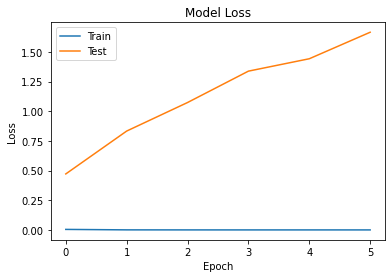

In [ ]:
# Plot loss over epochs
plt.title('Model Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('LSTM_len300_batch8_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

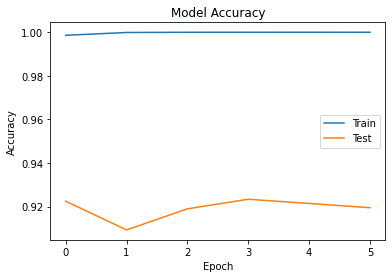

In [ ]:
# Plot accuracy over epochs
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('LSTM_len300_batch8_Accuracy.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
# Accuracy in test set
acc = model.evaluate(X_testT, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0], acc[1]))

2594/2594 [==============================] - 29s 11ms/step - loss: 1.6651 - accuracy: 0.9194
Test set
  Loss: 1.665
  Accuracy: 0.919


In [ ]:
# Predict on the test set
scores = model.predict(X_testT, verbose=1)

2594/2594 [==============================] - 27s 10ms/step


In [ ]:
# Determine sentiment score of test set
y_pred_1d = [decode_sentiment(score) for score in scores]

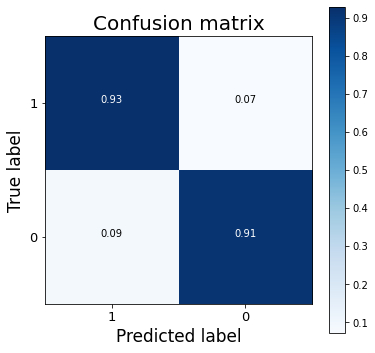

In [ ]:
# Confusion matrix
cnf_matrix = confusion_matrix(y_test['sentiment'].tolist(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=y_test.sentiment.unique(),
                      title='Confusion matrix')
plt.savefig('LSTM_len300_batch8_CF.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
# Classifcation score for model
print(classification_report(y_test['sentiment'].tolist(), y_pred_1d))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     41494
           1       0.93      0.91      0.92     41494

    accuracy                           0.92     82988
   macro avg       0.92      0.92      0.92     82988
weighted avg       0.92      0.92      0.92     82988

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     41494
           1       0.93      0.91      0.92     41494

    accuracy                           0.92     82988
   macro avg       0.92      0.92      0.92     82988
weighted avg       0.92      0.92      0.92     82988

